# Predicting the winner in an EPL Match

1) Clean the dataset
2) Split the dataset
3) Use classifiers to predict

In [2]:
import pandas as pd
#XGBoost is an prediction model that is a collection of weak prediction models like a decision tree
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from IPython.display import display
%matplotlib inline

In [2]:
pwd

'C:\\Users\\Ramesh Narayanan'

In [4]:
cd H:/DSP project/Data sets

H:\DSP project\Data sets


In [5]:
pwd

'H:\\DSP project\\Data sets'

In [6]:
# Read data
data = pd.read_csv('dataset_final.csv')

# Preview data.
display(data.tail())


#FTR - Full time result
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points - normalized
#DiffLP - Differenece in last years prediction

#Output - Full Time Result (H=Home Win, D=Draw, A=Away Win)

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
6075,H,1.263158,1.631579,L,D,L,W,L,W,-0.394737,0.394737,-0.368421,-0.236842,-3
6076,NH,1.210526,1.710526,W,W,L,D,L,W,-0.263158,0.789474,-0.500000,0.026316,6
6077,NH,1.157895,1.000000,L,L,W,W,W,D,-0.263158,-0.368421,0.157895,-0.131579,2
6078,NH,1.105263,1.552632,D,L,D,D,W,L,-0.368421,0.342105,-0.447368,-0.157895,7
6079,H,1.657895,1.105263,L,W,D,D,L,L,0.315789,-0.526316,0.552632,0.157895,-14


In [6]:
#Calculate the win % for a home team

# Total number of matches.
n_matches = data.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6080
Number of features: 13
Number of matches won by home team: 2816
Win rate of home team: 46.32%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000F4278DD2E8>,
      dtype=object)

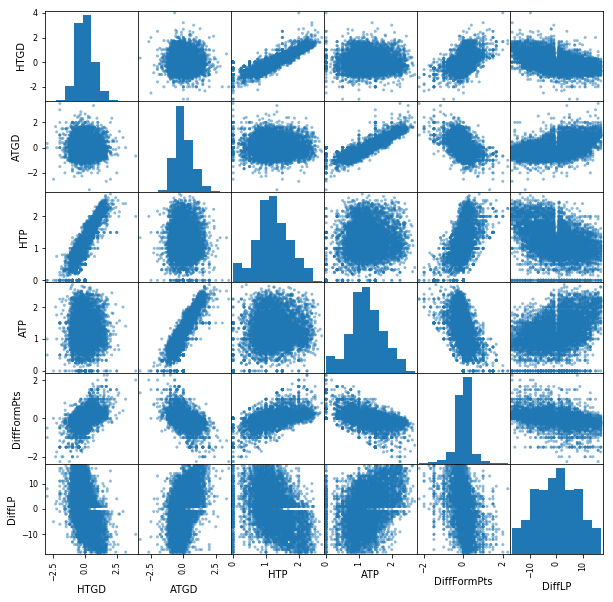

In [9]:
# Visualising distribution of data
#from pandas.tools.plotting import scatter_matrix
#import pandas.plotting.scatter_matrix
from pandas.plotting import scatter_matrix

#the scatter matrix is plotting each of the columns specified against each other column.
#You would have observed that the diagonal graph is defined as a histogram, which means that in the 
#section of the plot matrix where the variable is against itself, a histogram is plotted.

#Scatter plots show how much one variable is affected by another. 
#The relationship between two variables is called their correlation
#negative vs positive correlation

#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

# PREPARING THE DATA SET -

In [11]:
# Separate into feature set and target variable
#FTR = Full Time Result
#X_all is the feature matrix with all features except FTR
#Y_all is the predicting targe variable 
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale


#Differnet columns are on different scale. So scale them 

cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [12]:
X_all.tail()

,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
6075,0.105334,0.785040,L,D,L,W,L,W,-0.566626,0.559923,-0.368421,-0.236842,-0.372076
6076,0.004976,0.937854,W,W,L,D,L,W,-0.372763,1.142759,-0.500000,0.026316,0.744152
6077,-0.095382,-0.437476,L,L,W,W,W,D,-0.372763,-0.566895,0.157895,-0.131579,0.248051
6078,-0.195740,0.632225,D,L,D,D,W,L,-0.527853,0.482211,-0.447368,-0.157895,0.868177
6079,0.858020,-0.233723,L,W,D,D,L,L,0.480234,-0.800029,0.552632,0.157895,-1.736354


The form of each team is considered and important factor for a result. They were strings.
Convert them into numbers.

Code taken from : https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb

In [13]:
#last 3 wins for both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

#we want continous vars that are integers for our input data, so lets remove any categorical vars
def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (31 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_M', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_M', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_M', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_M', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_M', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_M', 'AM3_W', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP']


In [14]:
print ("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_M,HM1_W,HM2_D,HM2_L,HM2_M,HM2_W,...,AM2_W,AM3_D,AM3_L,AM3_M,AM3_W,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,-2.303259,-2.373125,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0.014963,-0.022914,0.0,0.0,0.000000
1,-2.303259,-2.373125,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0.014963,-0.022914,0.0,0.0,-0.496101
2,-2.303259,-2.373125,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0.014963,-0.022914,0.0,0.0,0.248051
3,-2.303259,-2.373125,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0.014963,-0.022914,0.0,0.0,0.124025
4,-2.303259,-2.373125,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0.014963,-0.022914,0.0,0.0,-1.240253


# MODEL FITTING

In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
#Code taken from https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb 
# Time taken to run the model can also be displayed.

from time import time 
# F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#p is the number of correct positive results divided by the number of all positive results, 
#r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [18]:
# Code taken from https://github.com/llSourcell/Predicting_Winning_Teams/blob/master/Prediction.ipynb
# Initialize the three models (XGBoost is initialized later)

clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')

Training a SVC using a training set size of 6030. . .
Trained model in 2.4117 seconds
Made predictions in 1.2528 seconds.
0.6120911793855301 0.6754560530679934
F1 score and accuracy score for training set: 0.6121 , 0.6755.
Made predictions in 0.0100 seconds.
F1 score and accuracy score for test set: 0.6818 , 0.7200.

Training a XGBClassifier using a training set size of 6030. . .
Trained model in 0.4809 seconds
Made predictions in 0.1461 seconds.
0.6422795533307664 0.6918739635157546
F1 score and accuracy score for training set: 0.6423 , 0.6919.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6190 , 0.6800.



C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print (clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)
Made predictions in 0.0120 seconds.
F1 score and accuracy score for training set: 0.6246 , 0.6771.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6190 , 0.6800.


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
